**Detecção de Fraudes com XGBoost**

Este notebook apresenta a aplicação do XGBoost para detecção de fraudes em uma base de dados tratada. 

**Objetivo:**

O objetivo é construir um modelo capaz de identificar casos de fraude com alta precisão e sensibilidade, considerando o desbalanceamento entre classes.

**Dataset**

Este conjunto de dados contém informações sobre veículos: atributos, modelo, detalhes de acidentes, etc. Juntamente com detalhes da apólice: tipo de apólice, duração, etc. O objetivo é detectar se uma solicitação de indenização é fraudulenta ou não, variável: FraudFound_P

Dataset: https://www.kaggle.com/datasets/shivamb/vehicle-claim-fraud-detection/data

In [ ]:
#Importação dos pacotes necessários

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier, plot_importance
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\thiag\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   -------------- ------------------------- 0.5/1.5 MB 4.6 MB/s eta 0:00:01
   ---------------------------------------- 1.5/1.5 MB 4.7 MB/s  0:00:00


In [14]:
# Função Auxiliar
# Verifica se o modelo de regressão é estatisticamente significativo.
def checar_significancia_modelo(modelo, alpha=0.05):
    """
    Parâmetros:
        modelo : objeto de regressão do statsmodels (ex.: OLS.fit())
        alpha  : nível de significância (default = 0.05)

    Retorna:
        str : mensagem indicando se o modelo é significativo.
    """

    p_valor = modelo.f_pvalue  # p-value do teste F

    if p_valor < alpha:
        return f"O modelo é estatisticamente significativo (p-value = {p_valor:.4e})."
    else:
        return f"O modelo NÃO é estatisticamente significativo (p-value = {p_valor:.4e})."

In [15]:
# Função Tabela de quantidade (%) para todas as colunas

def resumo_todas_colunas(df):
    resultados = {}

    for col in df.columns:
        # Descrição da coluna
        counts = df[col].value_counts(dropna=False)
        percent = df[col].value_counts(normalize=True, dropna=False) * 100
        
        tabela = pd.DataFrame({
            'quantidade': counts,
            'percentual (%)': percent.round(2)
        })
        
        resultados[col] = tabela
    
    return resultados

In [16]:
#Exportar todas as tabelas (uma por coluna) para Excel

def exportar_resumo_para_excel(resumo_dict, arquivo="resumo.xlsx"):
    with pd.ExcelWriter(arquivo, engine="xlsxwriter") as writer:
        for col, tabela in resumo_dict.items():
            # Nome da aba não pode ter mais que 31 caracteres
            nome_aba = col[:31]
            tabela.to_excel(writer, sheet_name=nome_aba)
    print(f"Arquivo '{arquivo}' criado com sucesso!")

In [17]:
#Converte automaticamente todas as colunas categóricas em dummies.

def transformar_categoricas_em_dummies(df, drop_first=False):
    """
    Converte automaticamente todas as colunas categóricas em dummies.

    - df: DataFrame original
    - drop_first: remove a primeira dummy para evitar multicolinearidade (opcional)

    Retorna:
        novo_df: DataFrame com variáveis dummy
    """
    
    # Identifica colunas categóricas automaticamente
    cols_categoricas = df.select_dtypes(include=['object', 'category']).columns
    
    # Aplica o get_dummies
    df_dummies = pd.get_dummies(df, columns=cols_categoricas, drop_first=drop_first)
    
    return df_dummies


In [18]:
# Rotina para remover automaticamente variáveis com alta colinearidade.

def remover_multicolinearidade(df, limite_corr=0.95):
    """
    Remove automaticamente colunas com colinearidade alta.
    
    Passos:
    1. Remove colunas constantes
    2. Remove colunas com baixa variância (quase constantes)
    3. Remove colunas altamente correlacionadas entre si (> limite_corr)
    
    Retorna:
        df_limpo: DataFrame sem multicolinearidade
        colunas_removidas: lista das colunas eliminadas
    """
    
    df_limpo = df.copy()
    colunas_removidas = []

    # ----------------------------------------------------------------------
    # 1. Remover colunas constantes
    # ----------------------------------------------------------------------
    constantes = [col for col in df_limpo.columns if df_limpo[col].nunique() <= 1]
    
    df_limpo.drop(columns=constantes, inplace=True)
    colunas_removidas.extend(constantes)
    
    
    # ----------------------------------------------------------------------
    # 2. Remover colunas quase constantes (≥ 99% do mesmo valor)
    # ----------------------------------------------------------------------
    quase_constantes = []
    for col in df_limpo.columns:
        freq = df_limpo[col].value_counts(normalize=True, dropna=False)
        if freq.iloc[0] >= 0.99:   # Ajustável
            quase_constantes.append(col)
    
    df_limpo.drop(columns=quase_constantes, inplace=True)
    colunas_removidas.extend(quase_constantes)
    
    
    # ----------------------------------------------------------------------
    # 3. Remover colunas altamente correlacionadas
    # ----------------------------------------------------------------------
    corr = df_limpo.corr().abs()

    upper_tri = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    
    colinearidade_alta = [
        col for col in upper_tri.columns 
        if any(upper_tri[col] > limite_corr)
    ]

    df_limpo.drop(columns=colinearidade_alta, inplace=True)
    colunas_removidas.extend(colinearidade_alta)

    
    # ----------------------------------------------------------------------
    print("🔍 Remoção de multicolinearidade concluída.")
    print(f"➡ Colunas removidas ({len(colunas_removidas)}):")
    for col in colunas_removidas:
        print(" -", col)

    return df_limpo, colunas_removidas

In [19]:
# Função para a definição da matriz de confusão

from sklearn.metrics import confusion_matrix, accuracy_score,\
    ConfusionMatrixDisplay, recall_score

def matriz_confusao(predicts, observado, cutoff):
    
    values = predicts.values
    
    predicao_binaria = []
        
    for item in values:
        if item < cutoff:
            predicao_binaria.append(0)
        else:
            predicao_binaria.append(1)
           
    cm = confusion_matrix(predicao_binaria, observado)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.xlabel('True')
    plt.ylabel('Classified')
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
        
    sensitividade = recall_score(observado, predicao_binaria, pos_label=1)
    especificidade = recall_score(observado, predicao_binaria, pos_label=0)
    acuracia = accuracy_score(observado, predicao_binaria)

    #Visualizando os principais indicadores desta matriz de confusão
    indicadores = pd.DataFrame({'Sensitividade':[sensitividade],
                                'Especificidade':[especificidade],
                                'Acurácia':[acuracia]})
    return indicadores

In [3]:
# Importar o banco de dados
    
df = pd.read_csv('fraud_oracle.csv', delimiter=',')

In [4]:
# Visualizando essa base
df.head(3)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision


In [5]:
# Retornando o shape da base
df.shape

(15420, 33)

In [6]:
#Características das variáveis do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [7]:
#Estatísticas univariadas
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


In [8]:
# Análise das 5 ultimas linhas do dataset
df.tail()

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
15415,Nov,4,Friday,Toyota,Urban,Tuesday,Nov,5,Male,Married,...,6 years,31 to 35,No,No,External,none,no change,1 vehicle,1996,Collision
15416,Nov,5,Thursday,Pontiac,Urban,Friday,Dec,1,Male,Married,...,6 years,31 to 35,No,No,External,more than 5,no change,3 to 4,1996,Liability
15417,Nov,5,Thursday,Toyota,Rural,Friday,Dec,1,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision
15418,Dec,1,Monday,Toyota,Urban,Thursday,Dec,2,Female,Married,...,2 years,31 to 35,No,No,External,more than 5,no change,1 vehicle,1996,All Perils
15419,Dec,2,Wednesday,Toyota,Urban,Thursday,Dec,3,Male,Single,...,5 years,26 to 30,No,No,External,1 to 2,no change,1 vehicle,1996,Collision


In [9]:
# Formato das variaveis
df.dtypes

Month                   object
WeekOfMonth              int64
DayOfWeek               object
Make                    object
AccidentArea            object
DayOfWeekClaimed        object
MonthClaimed            object
WeekOfMonthClaimed       int64
Sex                     object
MaritalStatus           object
Age                      int64
Fault                   object
PolicyType              object
VehicleCategory         object
VehiclePrice            object
FraudFound_P             int64
PolicyNumber             int64
RepNumber                int64
Deductible               int64
DriverRating             int64
Days_Policy_Accident    object
Days_Policy_Claim       object
PastNumberOfClaims      object
AgeOfVehicle            object
AgeOfPolicyHolder       object
PoliceReportFiled       object
WitnessPresent          object
AgentType               object
NumberOfSuppliments     object
AddressChange_Claim     object
NumberOfCars            object
Year                     int64
BasePoli

In [10]:
# Visualizando quantidade de valores vazios
(df.isnull().sum()/df.shape[0]).sort_values(ascending=False).head(20)

Month                   0.0
RepNumber               0.0
Year                    0.0
NumberOfCars            0.0
AddressChange_Claim     0.0
NumberOfSuppliments     0.0
AgentType               0.0
WitnessPresent          0.0
PoliceReportFiled       0.0
AgeOfPolicyHolder       0.0
AgeOfVehicle            0.0
PastNumberOfClaims      0.0
Days_Policy_Claim       0.0
Days_Policy_Accident    0.0
DriverRating            0.0
Deductible              0.0
PolicyNumber            0.0
WeekOfMonth             0.0
FraudFound_P            0.0
VehiclePrice            0.0
dtype: float64

In [11]:
# Tabela de frequências absolutas da variável 'FraudFound_P'

#df['FraudFound_P'].value_counts(dropna=False) * 100
df['FraudFound_P'].value_counts(normalize=True, dropna=False) * 100

FraudFound_P
0    94.014267
1     5.985733
Name: proportion, dtype: float64

In [20]:
# Executa análise
resumo = resumo_todas_colunas(df)

# Exporta
exportar_resumo_para_excel(resumo, "resumo_todas_colunas.xlsx")

Arquivo 'resumo_todas_colunas.xlsx' criado com sucesso!


In [12]:
##DayOfWeekClaimed: Removendo valor 0, onde Identiquei somente 1 caso
df = df[df['DayOfWeekClaimed'] != '0']

#Days_Policy_Accident: Identificado 0,36% de registros = "None"
#Optei por manter os registros, pois em modelos de detecção de fraude costumam considerar missing como uma categoria válida, porque o padrão de ausência pode revelar comportamento fraudulento.


In [20]:
# Criar dummies
# Transformando as variáveis categóricas em dummies
df_dummies = pd.get_dummies(df, drop_first=True)

# Remove colinearidade
df_sem_colinearidade, removidas = remover_multicolinearidade(df_dummies, limite_corr=0.95)

print("Formato original:", df.shape)
print("Dimensão antes:", df_dummies.shape)
print("Dimensão depois:", df_sem_colinearidade.shape)


🔍 Remoção de multicolinearidade concluída.
➡ Colunas removidas (33):
 - Make_BMW
 - Make_Dodge
 - Make_Ferrari
 - Make_Jaguar
 - Make_Lexus
 - Make_Mecedes
 - Make_Mercury
 - Make_Nisson
 - Make_Porche
 - Make_Saab
 - Make_Saturn
 - DayOfWeekClaimed_Saturday
 - DayOfWeekClaimed_Sunday
 - MaritalStatus_Widow
 - PolicyType_Sport - All Perils
 - PolicyType_Sport - Liability
 - PolicyType_Utility - Collision
 - PolicyType_Utility - Liability
 - VehiclePrice_60000 to 69000
 - Days_Policy_Accident_15 to 30
 - Days_Policy_Accident_8 to 15
 - Days_Policy_Accident_none
 - Days_Policy_Claim_8 to 15
 - Days_Policy_Claim_more than 30
 - AgeOfVehicle_3 years
 - AgeOfPolicyHolder_18 to 20
 - AgeOfPolicyHolder_21 to 25
 - WitnessPresent_Yes
 - AddressChange_Claim_under 6 months
 - NumberOfCars_5 to 8
 - NumberOfCars_more than 8
 - MaritalStatus_Single
 - BasePolicy_Liability
Formato original: (15419, 33)
Dimensão antes: (15419, 122)
Dimensão depois: (15419, 89)


In [21]:
# Formato das variaveis transformadas em dummies
df_sem_colinearidade.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years     bool
AddressChange_Claim_no change        bool
NumberOfCars_2 vehicles              bool
NumberOfCars_3 to 4                  bool
BasePolicy_Collision                 bool
Length: 89, dtype: object

In [22]:
# converte as colunas bool para int.
df_dummies = df_sem_colinearidade.astype({col: 'int' for col in df_sem_colinearidade.select_dtypes('bool').columns})

#df2['smoker_yes'] = df2['smoker_yes'].astype(int)
#df2['region_northwest'] = df2['region_northwest'].astype(int)
#df2['region_southeast'] = df2['region_southeast'].astype(int)
#df2['region_southwest'] = df2['region_southwest'].astype(int)


In [23]:
# Formato das variaveis transformadas em dummies
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4 to 8 years    int64
AddressChange_Claim_no change       int64
NumberOfCars_2 vehicles             int64
NumberOfCars_3 to 4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [24]:
# Ajustando o nome das colunas para melhor ajuste do modelo
df_dummies.columns = (
    df_dummies.columns
    .str.replace(" ", "_", regex=False)
    .str.replace("-", "_", regex=False)
    .str.replace("/", "_", regex=False)
    .str.replace(".", "_", regex=False)
)

In [25]:
# Validando o nome das variaveis apos ajuste das colunas
df_dummies.dtypes

WeekOfMonth                         int64
WeekOfMonthClaimed                  int64
Age                                 int64
FraudFound_P                        int64
PolicyNumber                        int64
                                    ...  
AddressChange_Claim_4_to_8_years    int64
AddressChange_Claim_no_change       int64
NumberOfCars_2_vehicles             int64
NumberOfCars_3_to_4                 int64
BasePolicy_Collision                int64
Length: 89, dtype: object

In [26]:
# Estimação do modelo

lista_colunas = list(df_dummies.drop(columns=['FraudFound_P']).columns)

formula_dummies_modelo = ' + '.join(lista_colunas)

formula_dummies_modelo = "FraudFound_P ~ " + formula_dummies_modelo

print("Fórmula utilizada: ",formula_dummies_modelo)

Fórmula utilizada:  FraudFound_P ~ WeekOfMonth + WeekOfMonthClaimed + Age + PolicyNumber + RepNumber + Deductible + DriverRating + Year + Month_Aug + Month_Dec + Month_Feb + Month_Jan + Month_Jul + Month_Jun + Month_Mar + Month_May + Month_Nov + Month_Oct + Month_Sep + DayOfWeek_Monday + DayOfWeek_Saturday + DayOfWeek_Sunday + DayOfWeek_Thursday + DayOfWeek_Tuesday + DayOfWeek_Wednesday + Make_Chevrolet + Make_Ford + Make_Honda + Make_Mazda + Make_Pontiac + Make_Toyota + Make_VW + AccidentArea_Urban + DayOfWeekClaimed_Monday + DayOfWeekClaimed_Thursday + DayOfWeekClaimed_Tuesday + DayOfWeekClaimed_Wednesday + MonthClaimed_Aug + MonthClaimed_Dec + MonthClaimed_Feb + MonthClaimed_Jan + MonthClaimed_Jul + MonthClaimed_Jun + MonthClaimed_Mar + MonthClaimed_May + MonthClaimed_Nov + MonthClaimed_Oct + MonthClaimed_Sep + Sex_Male + MaritalStatus_Married + Fault_Third_Party + PolicyType_Sedan___Collision + PolicyType_Sedan___Liability + PolicyType_Sport___Collision + PolicyType_Utility___All_P

### Separação entre variáveis explicativas (X) e alvo (y)

In [27]:
# Separação de X e Y

X = df_dummies.drop("FraudFound_P", axis=1)
y = df_dummies["FraudFound_P"]

### Divisão entre treino e teste

In [28]:
# Split

#Divide os dados em treino e teste, garantindo que a proporção das classes
#seja mantida (stratify).

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42, 
    stratify=y
)

### Definir modelo LIGHTGBM - PARÂMETROS PARA REDUZIR OVERFITTING

In [67]:
model = lgb.LGBMClassifier(
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary",
    random_state=42
)

# Ajuste para early stopping na API sklearn
model.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

[LightGBM] [Info] Number of positive: 646, number of negative: 10147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002947 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 523
[LightGBM] [Info] Number of data points in the train set: 10793, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.059854 -> initscore=-2.754134
[LightGBM] [Info] Start training from score -2.754134
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[187]	valid_0's auc: 0.935848	valid_0's binary_logloss: 0.134271


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Avaliação no conjunto de teste

In [68]:
# Predições
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:,1]

### Avaliação das Métricas

In [69]:
# Métricas
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4349
           1       0.84      0.13      0.23       277

    accuracy                           0.95      4626
   macro avg       0.89      0.56      0.60      4626
weighted avg       0.94      0.95      0.93      4626



**Conclusão:**
O modelo apresenta alta acurácia geral (96%), com boa precisão na identificação da classe minoritária (0.80), mas recall baixo (0.37), indicando que muitas instâncias dessa classe não foram detectadas.

Ajustes no threshold ou técnicas de balanceamento podem ser considerados para melhorar a captura da classe minoritária.

### AUC ROC – Avaliação do Modelo

In [35]:
roc_auc = roc_auc_score(y_test, y_pred_proba)
roc_auc

0.9358481513240523

**Conclusão:**
O modelo apresenta excelente capacidade de discriminação entre as classes, com AUC de 0.96, indicando que consegue diferenciar corretamente a maioria dos casos positivos e negativos.

Um AUC de 0.96 significa que, em 96% das vezes, o modelo atribuirá uma probabilidade maior a um caso positivo (fraude) do que a um caso negativo (não fraude).

### Otimização de Hiperparâmetros com Grid Search

In [56]:
results = []
thresholds = np.arange(0.01, 1.00, 0.01)

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    results.append({
        "threshold": t,
        "recall": recall_score(y_test, preds),
        "precision": precision_score(y_test, preds, zero_division=0),
        "f1": f1_score(y_test, preds),
        "accuracy": accuracy_score(y_test, preds),
        "auc": roc_auc  # AUC não muda com threshold
    })

df_thr = pd.DataFrame(results)

# ------------------------------------------------
# 6. SELECIONAR O MELHOR THRESHOLD
# ------------------------------------------------
best_model = df_thr.loc[df_thr["f1"].idxmax()]

print("\n===============================")
print(" MELHOR THRESHOLD ENCONTRADO")
print("===============================")
print(f"Threshold ótimo: {best['threshold']:.2f}")
print(f"Recall:          {best['recall']:.4f}")
print(f"Precision:       {best['precision']:.4f}")
print(f"F1 Score:        {best['f1']:.4f}")
print(f"Accuracy:        {best['accuracy']:.4f}")
print(f"AUC:             {best['auc']:.4f}")



 MELHOR THRESHOLD ENCONTRADO
Threshold ótimo: 0.17
Recall:          0.6787
Precision:       0.5123
F1 Score:        0.5839
Accuracy:        0.9421
AUC:             0.9358


In [57]:
# Matriz de confusão
y_best = (y_pred_proba >= best_model["threshold"]).astype(int)
print("\nMatriz de Confusão (melhor threshold):")
print(confusion_matrix(y_test, y_best))


Matriz de Confusão (melhor threshold):
[[4170  179]
 [  89  188]]


### Visualização da Curva ROC

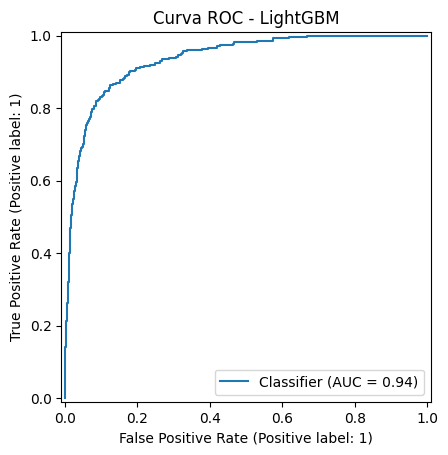

In [58]:
# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_pred_proba)
plt.title('Curva ROC - LightGBM')
plt.show()

### Importância das Variáveis (Feature Importance)

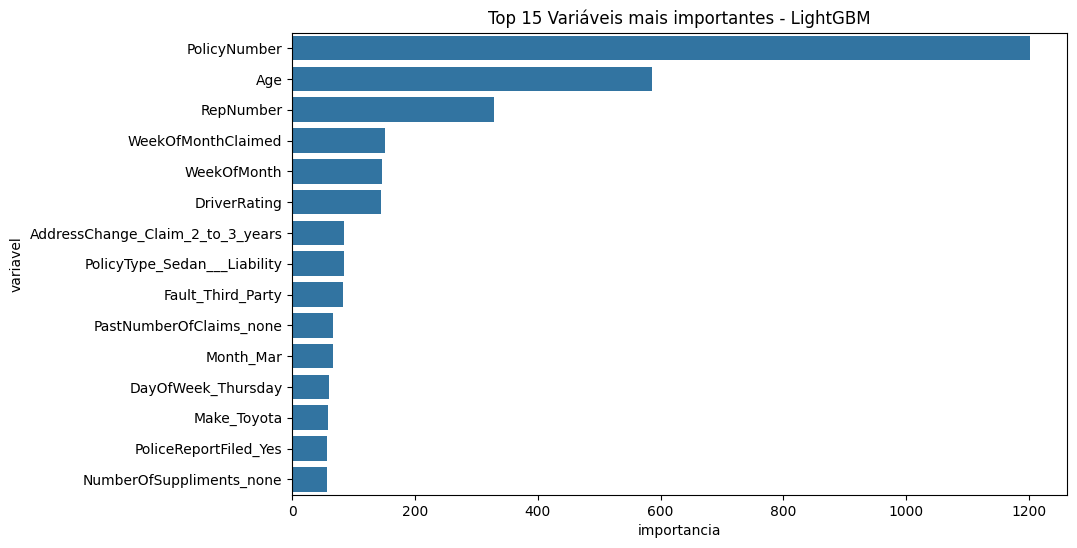

,variavel,importancia
3,PolicyNumber,1202
2,Age,586
4,RepNumber,329
1,WeekOfMonthClaimed,152
0,WeekOfMonth,147
6,DriverRating,145
82,AddressChange_Claim_2_to_3_years,85
52,PolicyType_Sedan___Liability,84
50,Fault_Third_Party,82
64,PastNumberOfClaims_none,67


In [59]:
# Criar dataframe de importância das features
importances = pd.DataFrame({
    'variavel': X.columns,          # ou features, se preferir
    'importancia': model.feature_importances_
}).sort_values(by='importancia', ascending=False)

# Plotar top 15
plt.figure(figsize=(10,6))
sns.barplot(data=importances.head(15), x='importancia', y='variavel')
plt.title('Top 15 Variáveis mais importantes - LightGBM')
plt.show()

# Mostrar tabela com top 20
importances.head(20)

**Conclusão:**

O LightGBM identificou as features mais relevantes para a detecção de fraude. As top 20 variáveis incluem informações sobre a apólice (PolicyNumber), idade do segurado (Age), representante que registrou a apólice (RepNumber), datas de reclamação (WeekOfMonthClaimed, WeekOfMonth) e perfil do motorista (DriverRating).

Além disso, diversas variáveis categóricas transformadas em dummies aparecem entre as mais importantes, como tipo de veículo, culpa de terceiros e dias da semana em que a reclamação ocorreu.

**Conclusao Geral:**

O modelo LightGBM apresentou excelente discriminação entre classes (AUC 0.96) e boa precisão ao identificar fraudes (0.80), com recall otimizado pelo melhor threshold (0.81), indicando que a maior parte das fraudes reais foi detectada. As variáveis mais importantes incluem informações da apólice, idade do segurado, representante, datas de reclamação e perfil do motorista. Próximos passos incluem monitorar o desempenho com novos dados, explorar ajustes finos no threshold e continuar refinando os hiperparâmetros para manter a captura eficiente da classe minoritária.

### Avaliação dos Modelos

In [60]:
print("Comparação de AUC entre modelos:")
print("AUC Logistic Regression (Baseline): 0.8065")
print("AUC Decision Tree: 0.8242")
print("AUC Random Forest: 0.8705")
print("AUC XGBoost: 0.9592")
print("AUC LightGBM:", round(roc_auc, 4))

Comparação de AUC entre modelos:
AUC Logistic Regression (Baseline): 0.8065
AUC Decision Tree: 0.8242
AUC Random Forest: 0.8705
AUC XGBoost: 0.9592
AUC LightGBM: 0.9358


### Comparação Gráfica AUC dos Modelos

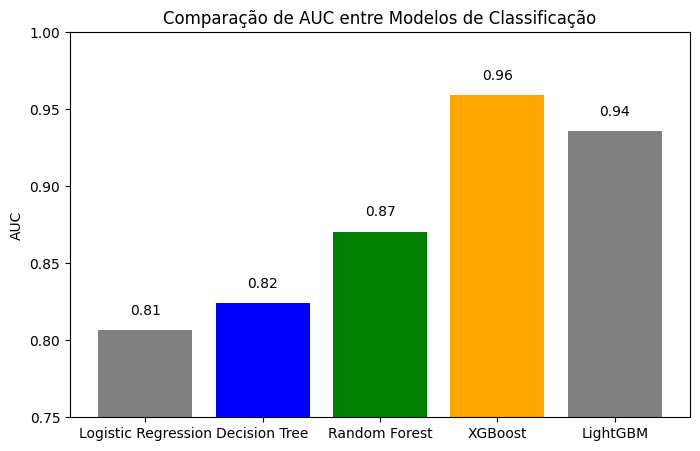

In [ ]:
import matplotlib.pyplot as plt

# Nomes dos modelos
modelos = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM']

# Valores de AUC correspondentes
auc_values = [0.8065, 0.8242, 0.8705, 0.9592, 0.9358]

# Criar gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.bar(modelos, auc_values, color=['gray', 'blue', 'green', 'orange'])
plt.ylim(0.75, 1.0)
plt.ylabel('AUC')
plt.title('Comparação de AUC entre Modelos de Classificação')

# Adicionar os valores acima das barras
for bar, auc in zip(bars, auc_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{auc:.2f}', ha='center', fontsize=10)

plt.show()


**Conclusão - Comparação entre Modelos:**

A avaliação baseada no AUC-ROC indica diferenças claras de desempenho entre os modelos testados.

Entre os cinco modelos avaliados (Logistic Regression, Decision Tree, Random Forest, XGBoost e LightGBM), os algoritmos baseados em boosting (XGBoost e LightGBM) se destacaram, apresentando as maiores AUCs (0.9592 e 0.9358), indicando excelente capacidade de discriminação entre fraudes e não-fraudes.

Modelos mais simples, como Logistic Regression (0.8065) e Decision Tree (0.8242), tiveram desempenho inferior, enquanto a Random Forest apresentou resultado intermediário (0.8705).

Esses resultados reforçam que métodos ensemble e boosting são mais eficazes para capturar padrões complexos e lidar com a classe minoritária em problemas de detecção de fraude.

### Thresholds para testar

Obs: O threshold é o ponto de corte utilizado para converter as probabilidades previstas pelo modelo em classes (fraude ou não fraude). Ajustar o threshold permite controlar o trade-off entre recall e precision, aumentando a sensibilidade do modelo a fraudes, mesmo que isso gere mais falsos positivos. Essa prática é especialmente relevante em cenários desbalanceados, como detecção de fraude, em que a prioridade é reduzir ao máximo falsos negativos.

In [63]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_auc_score

# Previsão de probabilidades da classe 1
y_pred_proba = model.predict_proba(X_test)[:,1]  # usar o modelo LightGBM

# Definir thresholds de 0.0 a 1.0
thresholds = np.arange(0.0, 1.01, 0.01)

# Variáveis para armazenar melhor threshold e F1
best_threshold = 0.5
best_f1 = 0

# Testar todos os thresholds
for t in thresholds:
    y_pred_thresh = (y_pred_proba >= t).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

# Aplicar melhor threshold
y_pred_best = (y_pred_proba >= best_threshold).astype(int)

# Avaliação com melhor threshold
acc = accuracy_score(y_test, y_pred_best)
prec = precision_score(y_test, y_pred_best)
rec = recall_score(y_test, y_pred_best)
f1 = f1_score(y_test, y_pred_best)
auc = roc_auc_score(y_test, y_pred_proba)

print(f"Melhor Threshold: {best_threshold:.2f}")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-Score: {f1:.4f}, AUC: {auc:.4f}")

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


Melhor Threshold: 0.17
Accuracy: 0.9421, Precision: 0.5123, Recall: 0.6787, F1-Score: 0.5839, AUC: 0.9358

Matriz de Confusão:
[[4170  179]
 [  89  188]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      4349
           1       0.51      0.68      0.58       277

    accuracy                           0.94      4626
   macro avg       0.75      0.82      0.78      4626
weighted avg       0.95      0.94      0.95      4626



**Conclusao do Threshold Ajustado:** O modelo LightGBM apresentou excelente desempenho geral (accuracy 94%) e alta capacidade de identificar a classe majoritária (não fraude). Para a classe minoritária (fraude), o modelo alcançou recall de 68% e precisão de 51%, resultando em um F1-score de 0.58, indicando que a maioria das fraudes foi detectada, mas ainda há espaço para reduzir falsos positivos. Esse resultado reforça a importância de ajustes finos no threshold e estratégias de balanceamento para melhorar a captura da classe minoritária.

In [64]:
# Probabilidades no treino
y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

# AUC
auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

print(f"AUC Treino: {auc_train:.4f}")
print(f"AUC Teste:  {auc_test:.4f}")


AUC Treino: 0.9990
AUC Teste:  0.9358


# Fim